In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# from dotenv import load_dotenv
# load_dotenv('.env')

# import os
# token = os.getenv("GITHUB_TOKEN")
# username = 'alessandroardenghi'
# repo = 'SemanticSegmentation'

# Data Preparation and Exploration

We are given a dataset containing 15048 GeoTIFF files which contain an RGB image, the corresponding infrared image, the elevation map and a label map that gives each pixel a label from the following classes: <br>
- Impervious surface
- Building
- Low Vegetation
- Tree
- Car
- Clutter/Background 

Our task will be to train some semantic segmentation models that will be able to accurately predict pixel-level labels.

In [1]:
import random
import tensorflow as tf
import os
import math
import tensorflow as tf
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
from utils import read_tiff, plot_tiff, serialize_datapoint, parse_rgb_ir, plot_history, plot_inference_results, build_datasets, parse_rgb, plot_datapoints_from_datasets, parse_datapoint, split_datasets_by_grid, split_train_val, parse_easy
from models import build_base_model, build_shallow_unet
from tensorflow.keras.callbacks import ModelCheckpoint


## Data Selection

In this very brief subsection we analyse the original dataset, select a subset of 5000 images to train, validate and test our models and build 5 folds to perform 5-fold cross validation. 

In [2]:
random.seed(1)

datapoints = [f'data/{element}' for element in os.listdir('data') if element.endswith('.tif')]
print(f'Example Datapoints:\n{datapoints[:3]}\n')
print(f'# of Datapoints: {len(datapoints)}')

n_elements = 5000
selected_datapoints = random.sample(datapoints, n_elements)
random.shuffle(selected_datapoints)
print(f'# of randomly selected Datapoints: {len(selected_datapoints)}\n')

n_folds = 5
fold_size = n_elements // n_folds
folds = [selected_datapoints[i*fold_size: (i+1)*fold_size] for i in range(n_folds)]

# Sanity Check
for i, fold in enumerate(folds):
  print(f'n_datapoints in fold {i} = {len(fold)}')

Example Datapoints:
['data/0000030240-0000043232.tif', 'data/0000016800-0000032256.tif', 'data/0000032704-0000021280.tif']

# of Datapoints: 15048
# of randomly selected Datapoints: 5000

n_datapoints in fold 0 = 1000
n_datapoints in fold 1 = 1000
n_datapoints in fold 2 = 1000
n_datapoints in fold 3 = 1000
n_datapoints in fold 4 = 1000


Here we plot a few of the .tiff images both in RGB, infrared, elevation and segmentation mask.

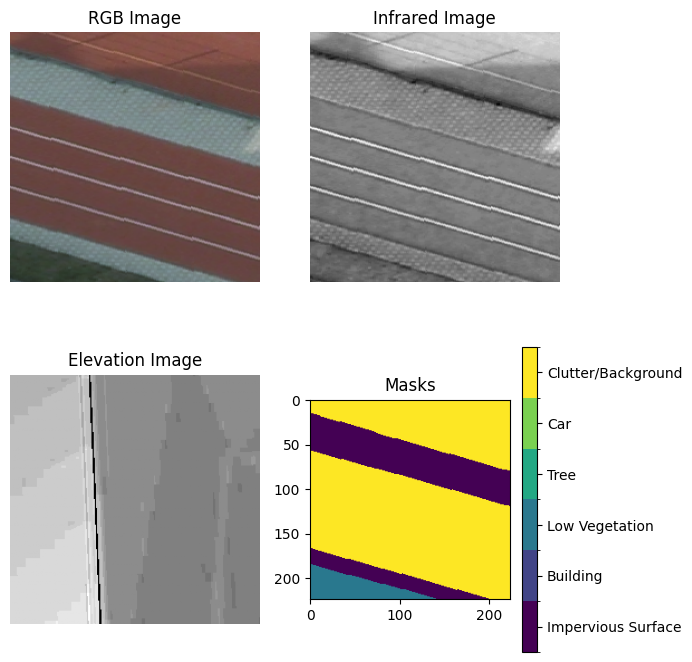

In [3]:
plot_tiff(folds[0][1], figsize=(7, 7))

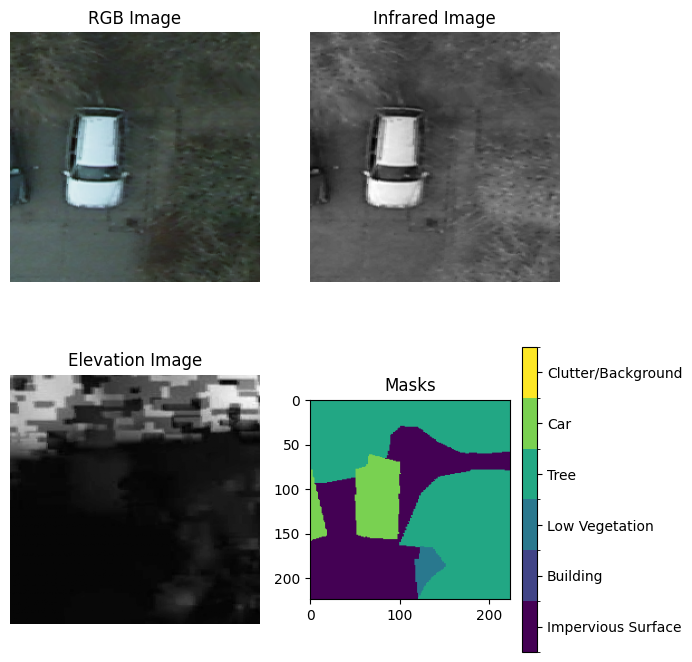

In [4]:
plot_tiff(folds[4][3], figsize=(7, 7))

Next, we build the TFRecord files that will be used during training

In [5]:
from tqdm import tqdm
pbar = tqdm(total=5000)
for i, fold in enumerate(folds):
  with tf.io.TFRecordWriter(f"TFRecord_dir/TFRecord_fold{i}.tfrecord") as writer:
    for datapoint in fold:
        serialized_datapoint = serialize_datapoint(datapoint)
        writer.write(serialized_datapoint)
        pbar.update(1)
pbar.close()

100%|██████████| 5000/5000 [00:49<00:00, 100.23it/s]


# Model Training

### Simple Convolutional Model

We start our analysis by implementing a simple convolutional model with just 2 convolutional layers with kernels of size (3, 3) and 32 and 6 channels respectively.

In [3]:
base_model = build_base_model((224, 224, 4))
base_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
base_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 6)    │         1,734 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,918 (11.40 KB)

 Trainable params: 2,918 (11.40 KB)

 Non-trainable params: 0 (0.00 B)

We will use the first 3 folds to train, the 4th fold to validate and the 5th fold to test the model. We choose a batch size of 16 and we build the functions _parse\_datapoint_ and _parse\_rgb\_ir_ that respectively parse a datapoint from a TFRecord file and return only its first 4 channels (i.e. RGB + Infrared) and the corresponding labels. <br>
Therefore in this instance we do not exploit the elevation information.

In [4]:
train_filenames = [
    "TFRecord_dir/TFRecord_fold0.tfrecord",
    "TFRecord_dir/TFRecord_fold1.tfrecord",
    "TFRecord_dir/TFRecord_fold2.tfrecord"
]
val_filenames = [
    "TFRecord_dir/TFRecord_fold3.tfrecord"]

test_filenames = [
    "TFRecord_dir/TFRecord_fold4.tfrecord"]

batch_size = 16

epochs = 20

To build the train dataset we use the .map function to apply the parse_rgb_ir function (which again returns the RGB image and Infrared Image + corresponding label) to the whole training TFRecord file. <br>
We choose 100 as buffer_size to limit the use of RAM and we choose a batch size of 16. <br>
The number of epochs is 20 because we do not have enough computational power to perform a longer training.

In [5]:
train_dataset, val_dataset, test_dataset = build_datasets(train_filenames,
                                                          val_filenames,
                                                          test_filenames,
                                                          parse_rgb_ir)

checkpoint = ModelCheckpoint(
    filepath='best_base_model.keras',  
    monitor='val_loss',           
    save_best_only=True,          
    mode='min',                   
    verbose=1    
)

In [6]:
steps_per_epoch = 3000 // batch_size 
history = base_model.fit(train_dataset,
                        epochs=epochs,
                        steps_per_epoch = steps_per_epoch,
                        validation_data=val_dataset, 
                        callbacks = [checkpoint])

Epoch 1/20


2025-02-23 10:04:54.554643: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144


  7/187 ━━━━━━━━━━━━━━━━━━━━ 39s 220ms/step - accuracy: 0.2007 - loss: 20.0904

KeyboardInterrupt: 

We performed the training on Colab with a T4 GPU and obtained the following trained model and the following history.

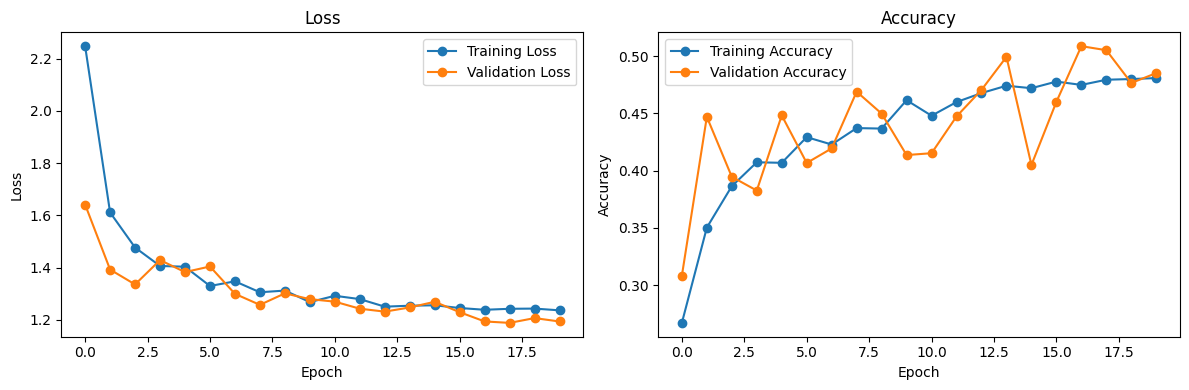

In [25]:
base_model = tf.keras.models.load_model('saved_models/base_model.keras')
base_history = plot_history('saved_models/base_model_history.json')

In [26]:
print(f'Best Validation Accuracy: {np.max(base_history["val_accuracy"]):.3f}\nFinal Validation Accuracy: {base_history["val_accuracy"][-1]:.3f}')

Best Validation Accuracy: 0.509
Final Validation Accuracy: 0.485


Next, we evaluate the model performance on the test set.

In [27]:
test_loss, test_accuracy = base_model.evaluate(test_dataset, steps=1000//batch_size)
print(f'Test Loss: {test_loss:.3f}')
print(f'Test Accuracy: {test_accuracy:.3f}')


62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.5097 - loss: 1.1739
Test Loss: 1.174
Test Accuracy: 0.515


We now plot some of the inference results against their ground truths

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


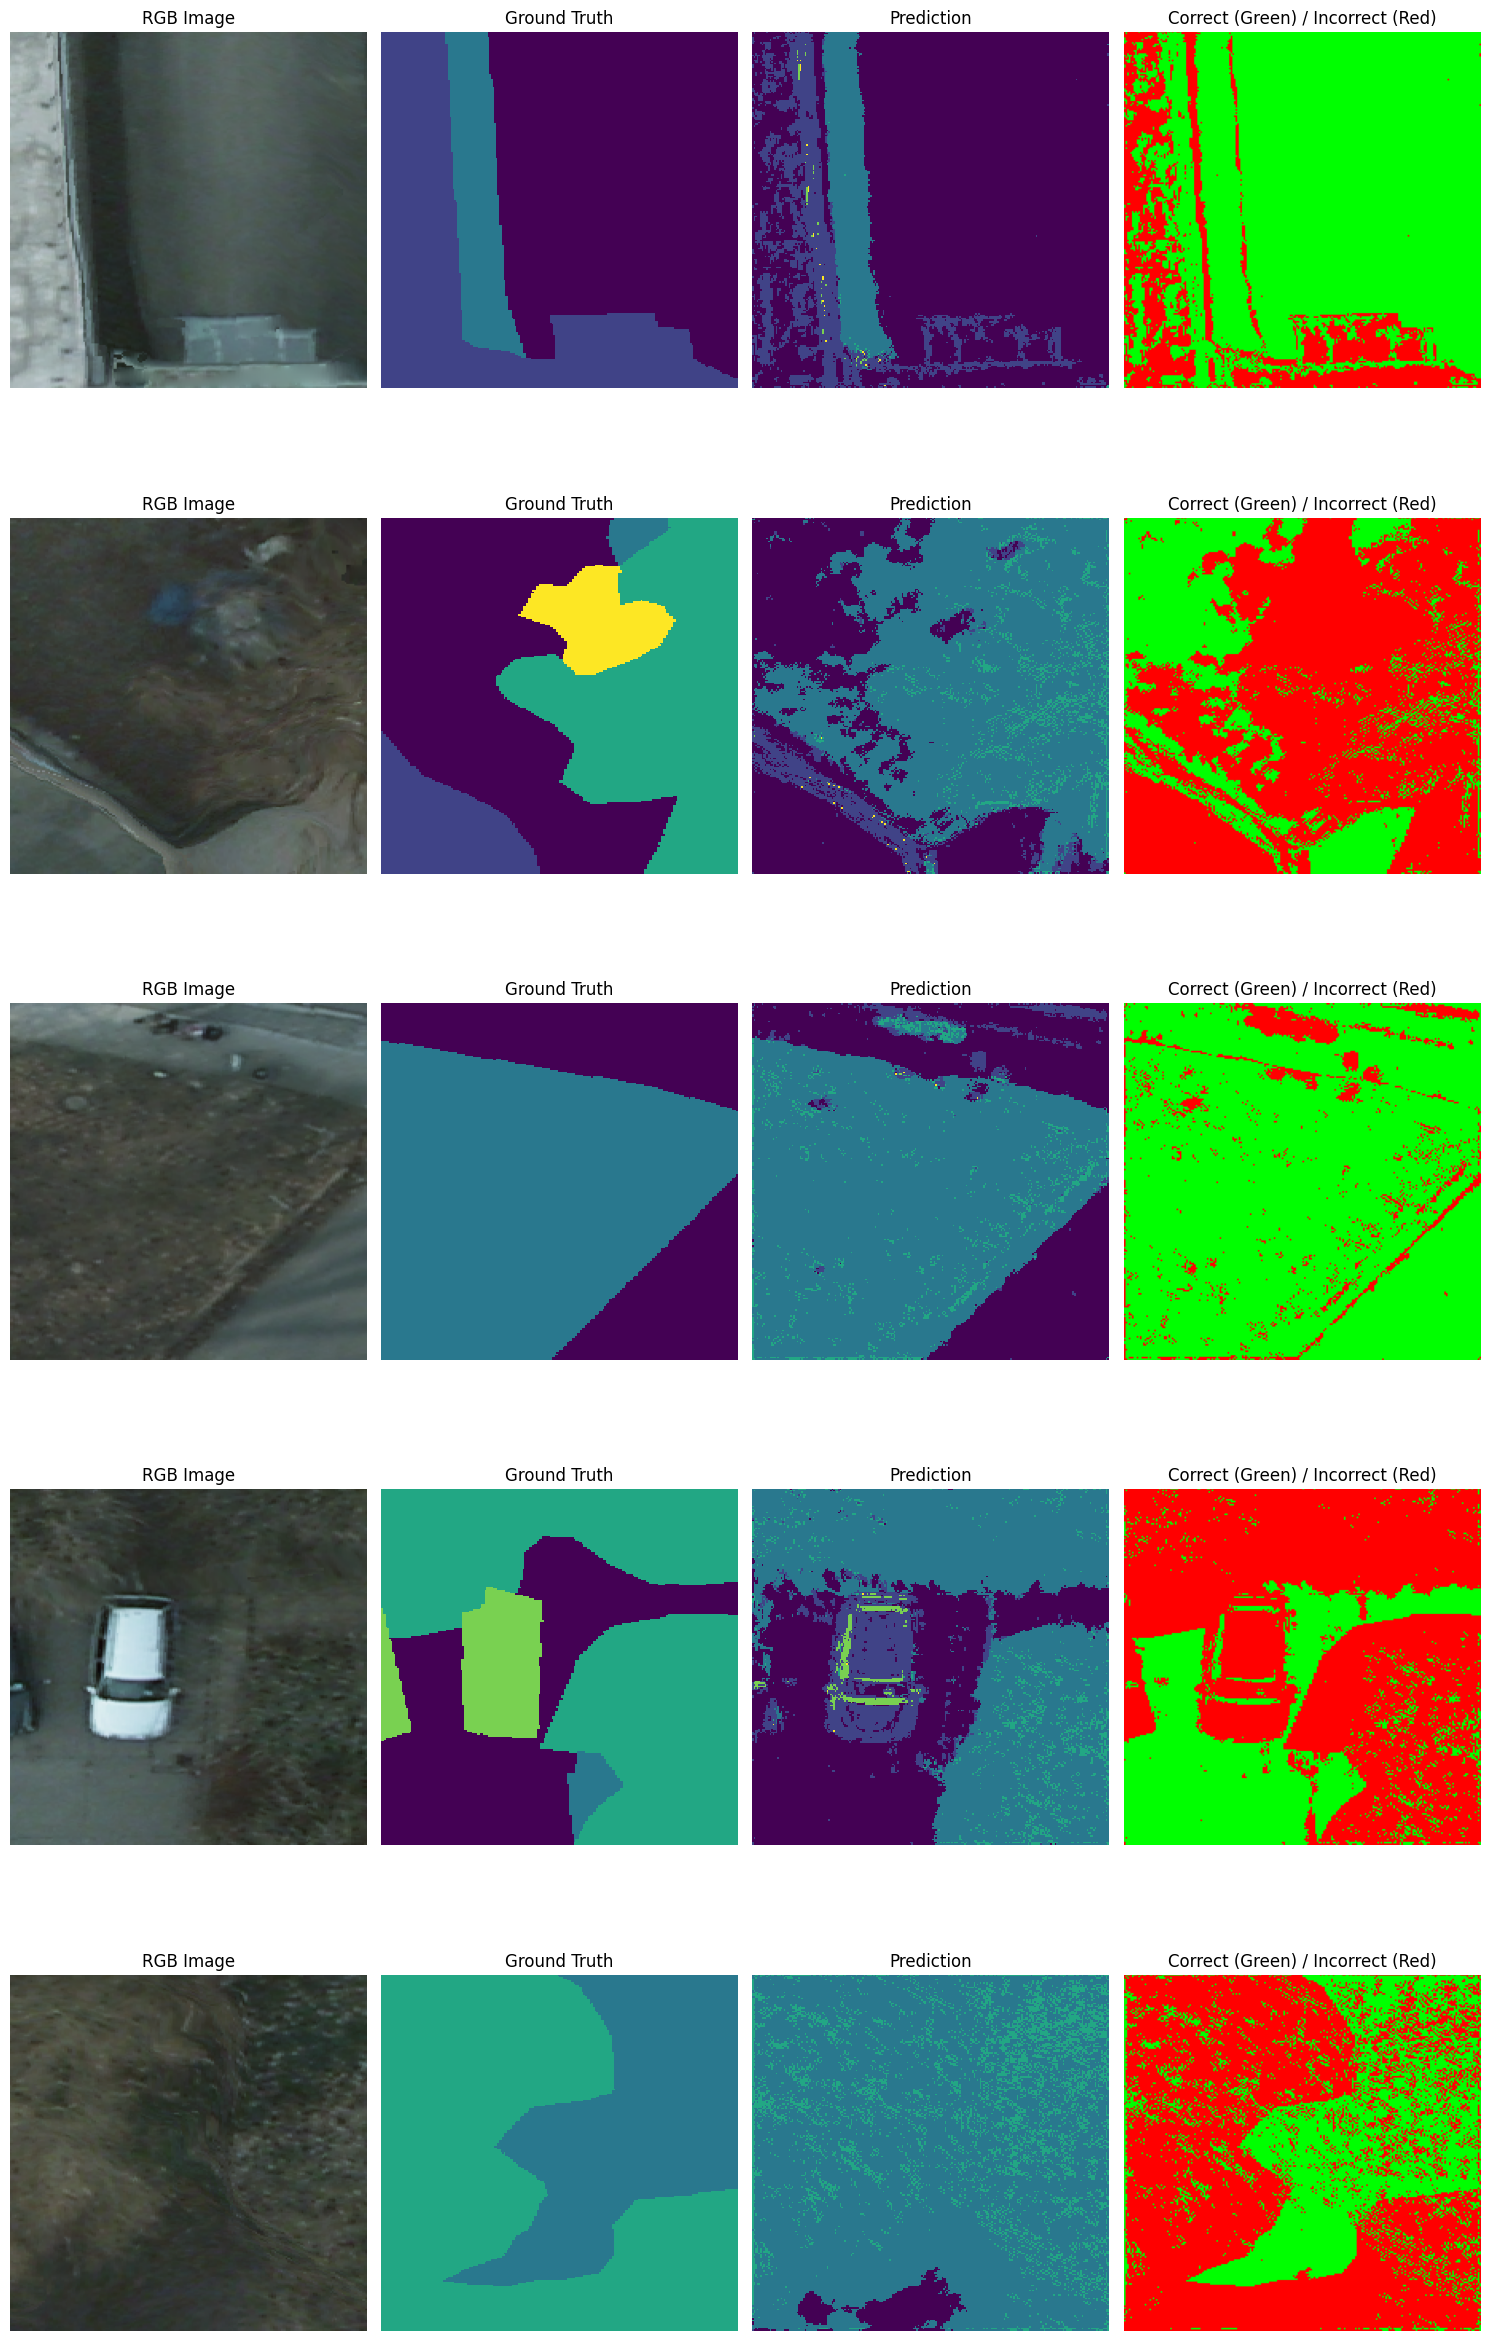

2025-02-22 15:03:16.128304: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [28]:
plot_inference_results(test_dataset, base_model, 5)

As we can see, the model is able to detect some structure, but is very imprecise and consistently mislabels the pixels.

### Shallow U-Net Model

To improve the performance on the task, we implement a shallow version of the famous U-Net architecture.

In [18]:
train_dataset, val_dataset, test_dataset = build_datasets(train_filenames,
                                                          val_filenames,
                                                          test_filenames,
                                                          parse_rgb)

unet_model = build_shallow_unet((224, 224, 5))
unet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
unet_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 224, 224,  │      1,472 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     36,928 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 112, 112,  │     36,928 │ conv2d_4[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 112, 112,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 224, 224,  │     36,896 │ concatenate[0][0] │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 224, 224,  │      9,248 │ conv2d_transpose… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 224, 224,  │      1,734 │ conv2d_transpose… │
│                     │ 6)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 141,702 (553.52 KB)

 Trainable params: 141,702 (553.52 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 20
steps_per_epoch = 3000 // batch_size
history = unet_model.fit(train_dataset, 
                    epochs=epochs, 
                    steps_per_epoch = steps_per_epoch,
                    validation_data=val_dataset, 
                    callbacks = [checkpoint])

Once again, we perform the training on Colab with a T4 GPU and obtain the following model and history.

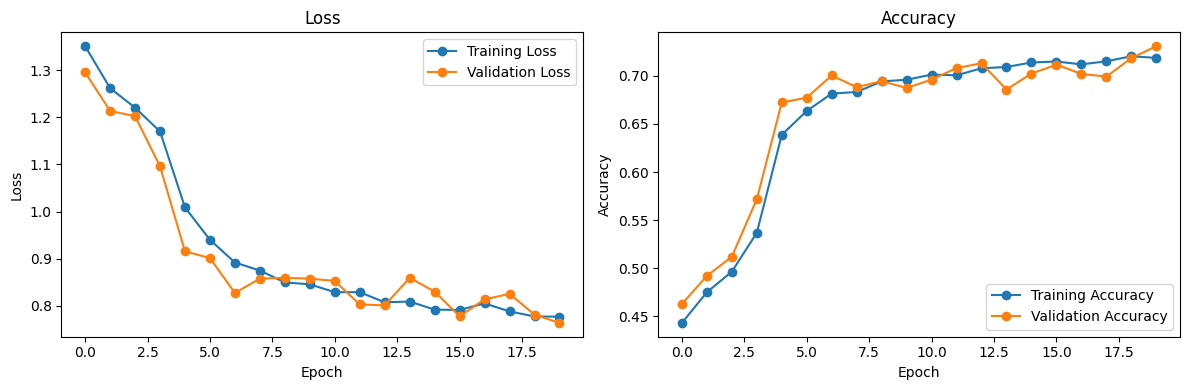

In [15]:
unet_model = tf.keras.models.load_model('saved_models/unet_model.keras')
unet_history = plot_history('saved_models/unet_history.json')

In [16]:
print(f'Best Validation Accuracy: {np.max(unet_history["val_accuracy"]):.3f}\nFinal Validation Accuracy: {unet_history["val_accuracy"][-1]:.3f}')

Best Validation Accuracy: 0.731
Final Validation Accuracy: 0.731


In [17]:
test_loss, test_accuracy = unet_model.evaluate(test_dataset, steps=1000//batch_size)
print(f'Test Loss: {test_loss:.3f}')
print(f'Test Accuracy: {test_accuracy:.3f}')


I0000 00:00:1740231911.770921 1032488 service.cc:148] XLA service 0x15f3faa00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740231911.771935 1032488 service.cc:156]   StreamExecutor device (0): Host, Default Version
2025-02-22 14:45:11.817933: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740231912.076986 1032488 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


62/62 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.7385 - loss: 0.7425
Test Loss: 0.739
Test Accuracy: 0.742


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


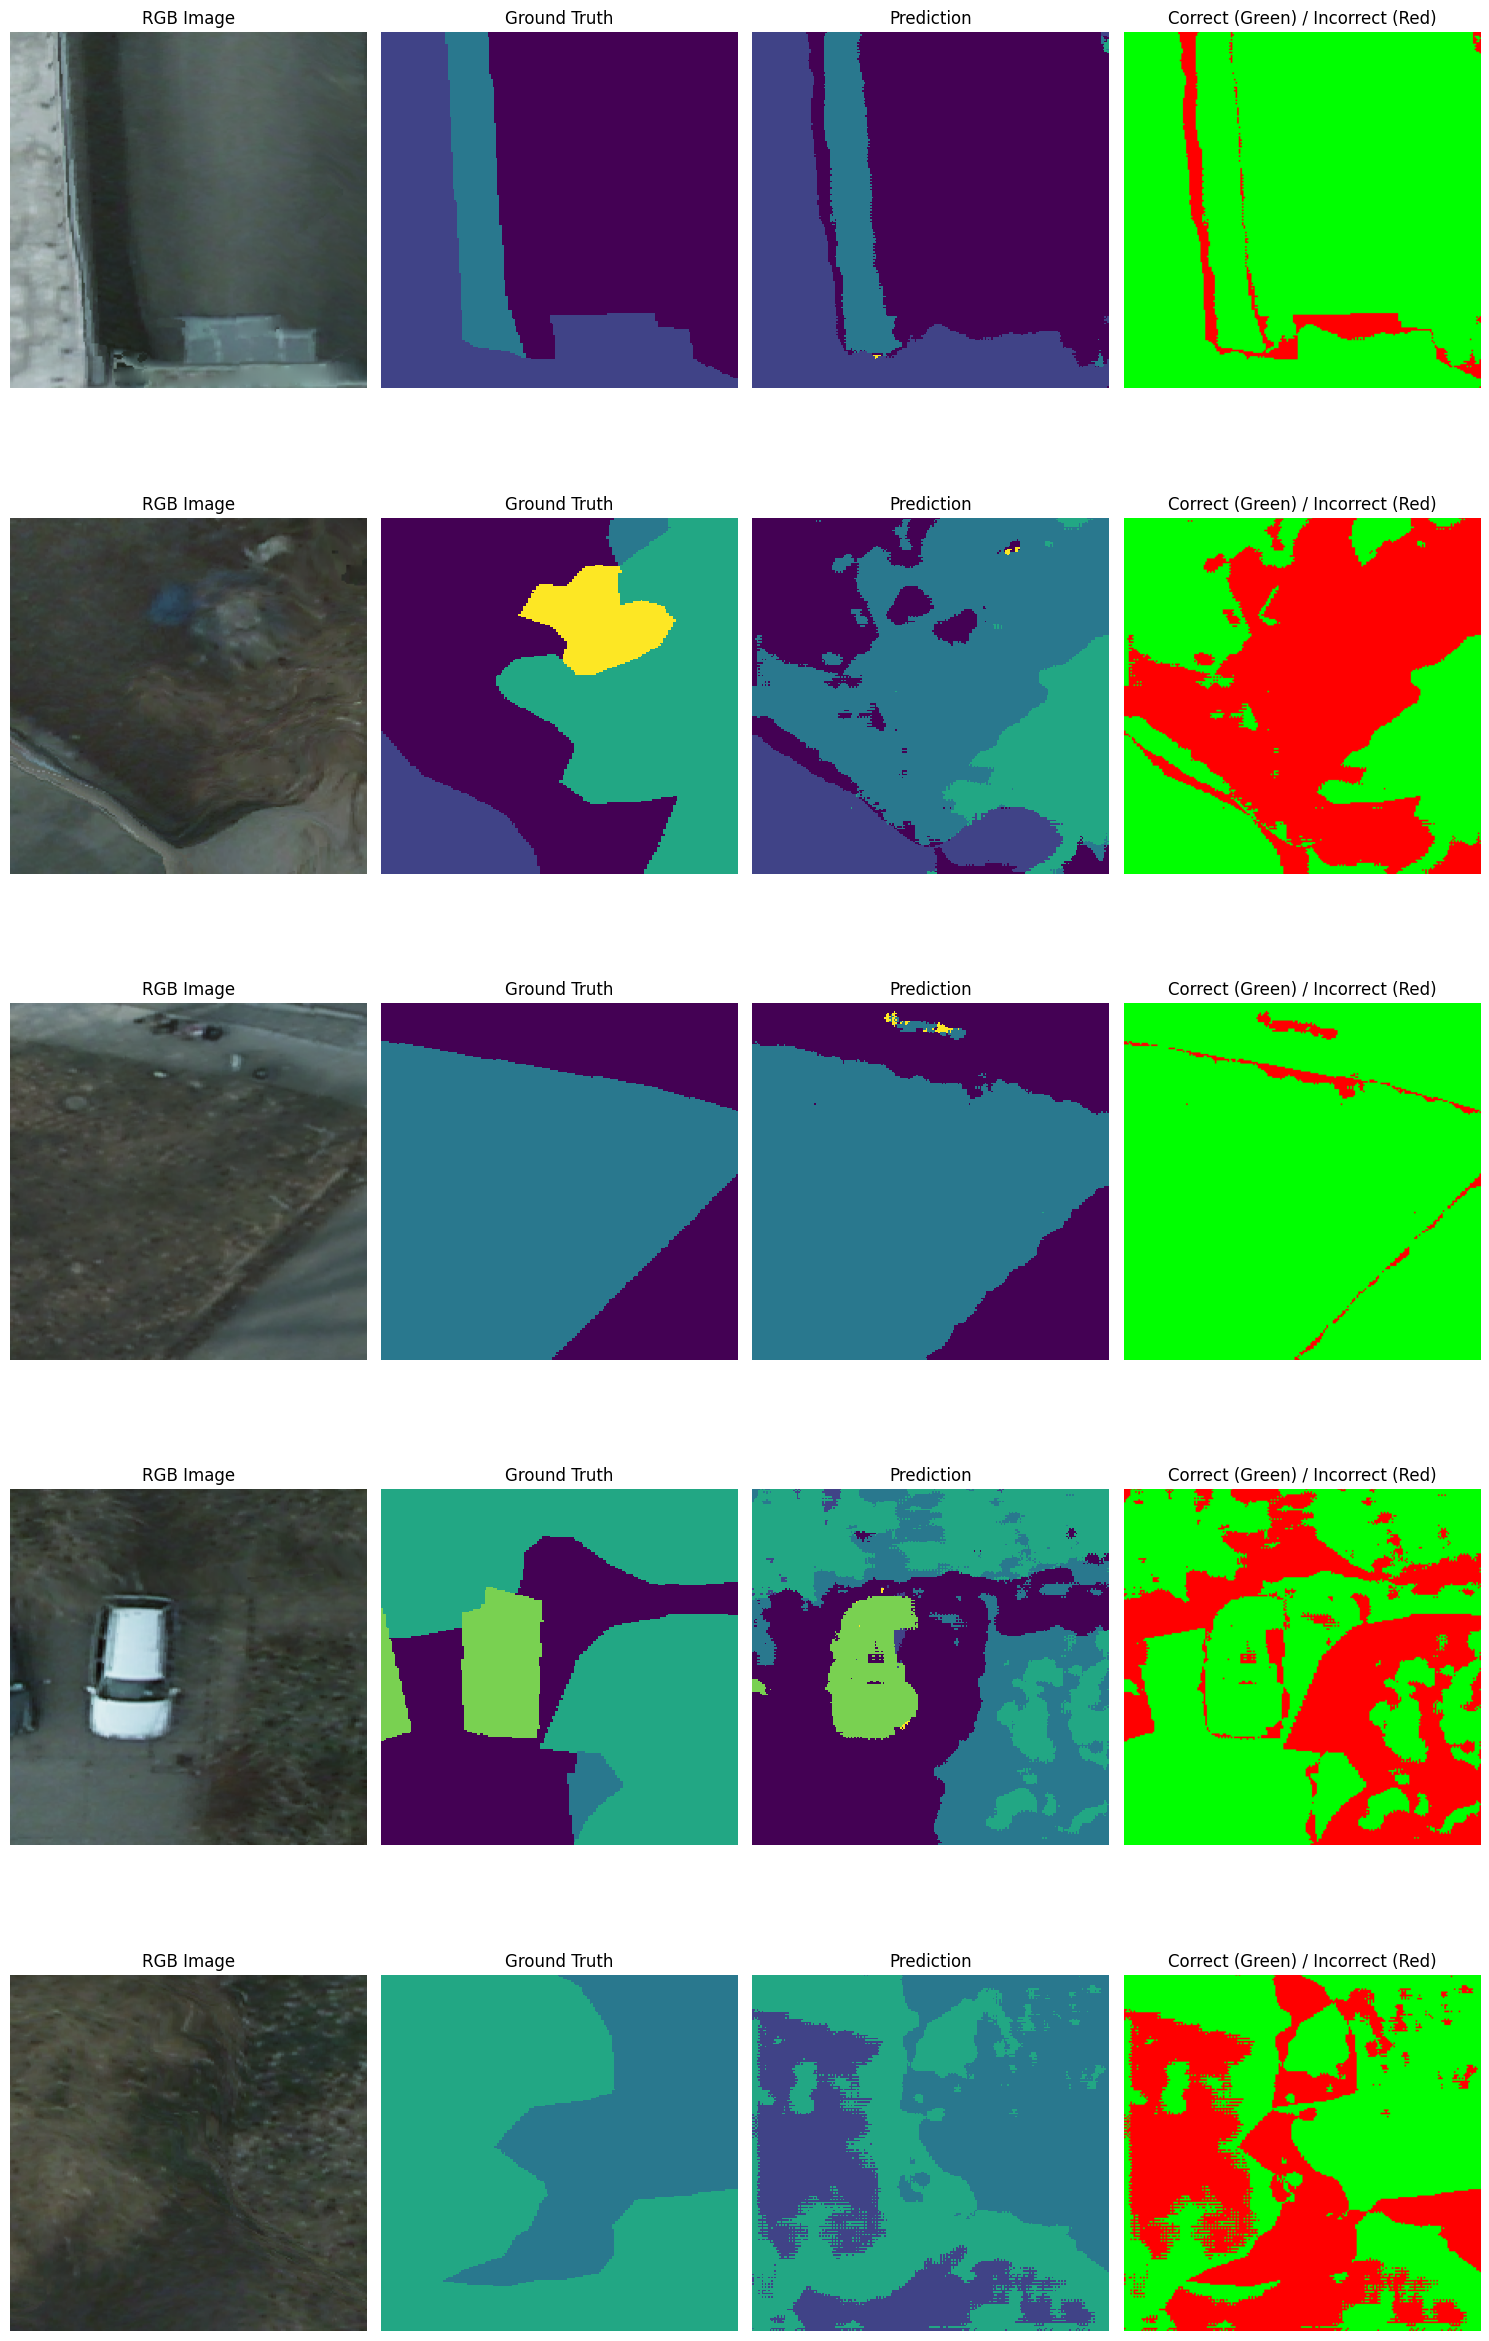

2025-02-22 14:47:56.404965: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:
plot_inference_results(test_dataset, unet_model, 5)

## New Train/Val/Test Split Method

In this section, we implement a different approach to train/val/test splitting, following some ideas expressed in the paper: _'A Generalizable and Accessible Approach to Machine Learning with Global Satellite Imagery'_ by Rolf et al. (2021).

In our first approach, we simply split the data into 3 training folds, 1 validation fold and 1 test fold. If we visualize the data in longitude/latitude space we obtain the following result.

2025-02-23 09:40:58.443377: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


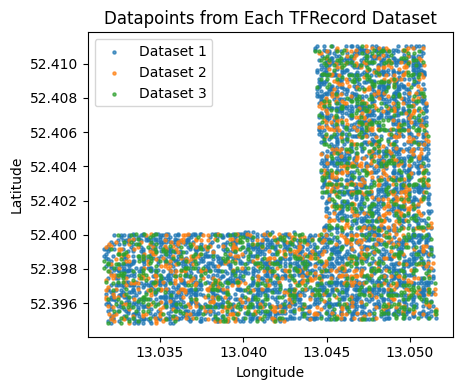

In [5]:
train = tf.data.TFRecordDataset(["TFRecord_dir/TFRecord_fold0.tfrecord",
                                 "TFRecord_dir/TFRecord_fold1.tfrecord",
                                 "TFRecord_dir/TFRecord_fold2.tfrecord"]).map(parse_datapoint)
val = tf.data.TFRecordDataset("TFRecord_dir/TFRecord_fold3.tfrecord").map(parse_datapoint)
test = tf.data.TFRecordDataset("TFRecord_dir/TFRecord_fold4.tfrecord").map(parse_datapoint)

plot_datapoints_from_datasets([train, val, test], figsize = (5, 4))

As we can see, the points were evely distributed in the space, and at least in the latitude/longitude space both the validation and test datasets were close to the training dataset. <br>
Now we try to implement the approach suggested in the paper, partitioning the latitude and longitude space into a grid according to some angles, then training on some grid cells and validating on others.

2025-02-23 10:17:15.333057: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144
2025-02-23 10:17:18.538089: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-23 10:17:21.683797: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


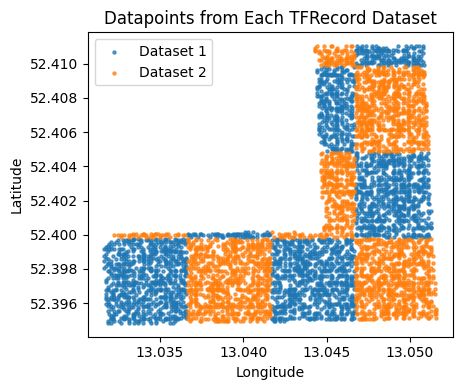

In [3]:
data = tf.data.TFRecordDataset(["TFRecord_dir/TFRecord_fold0.tfrecord",
                                 "TFRecord_dir/TFRecord_fold1.tfrecord",
                                 "TFRecord_dir/TFRecord_fold2.tfrecord",
                                 "TFRecord_dir/TFRecord_fold3.tfrecord",
                                 "TFRecord_dir/TFRecord_fold4.tfrecord"]).map(parse_datapoint)
train, test = split_datasets_by_grid([data], grid_size=0.005)
plot_datapoints_from_datasets([train, test], figsize = (5, 4))

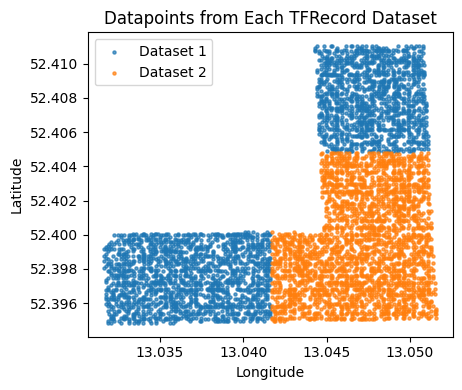

In [8]:
train, test = split_datasets_by_grid([data], grid_size=0.01)
plot_datapoints_from_datasets([train, test], figsize = (5, 4))

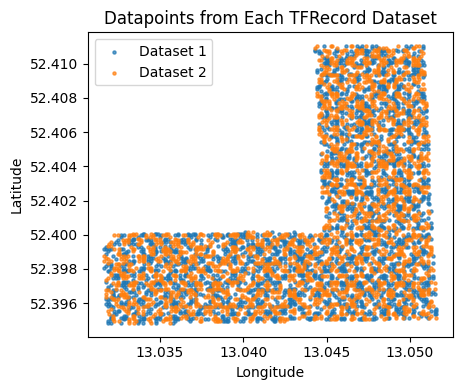

In [9]:
train, test = split_datasets_by_grid([data], grid_size=0.0005)
plot_datapoints_from_datasets([train, test], figsize = (5, 4))

2025-02-23 09:48:55.497557: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


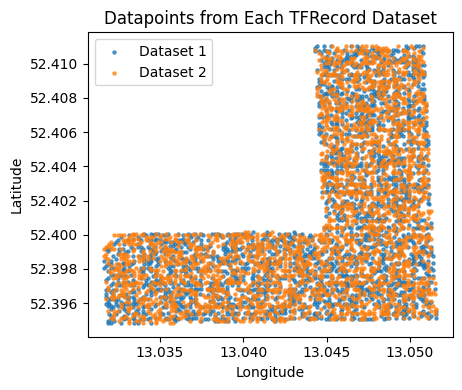

In [10]:
train, test = split_datasets_by_grid([data], grid_size=0.0001)
plot_datapoints_from_datasets([train, test], figsize = (5, 4))

We will train models for these angles and see how the performance changes. 

In [ ]:
train, test = split_datasets_by_grid([data], grid_size=0.0005)
train, val = split_train_val(train, split_ratio=0.8)
train_dataset, val_dataset, test_dataset = build_datasets(train, val, test, parse_easy)

2025-02-23 10:17:28.123070: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
checkpoint = ModelCheckpoint(
    filepath='model.keras',  
    monitor='val_loss',           
    save_best_only=True,          
    mode='min',                   
    verbose=1    
)
batch_size = 16
epochs = 20
history = unet_model.fit(train_dataset,
                        epochs=epochs,
                        #steps_per_epoch = steps_per_epoch,
                        validation_data=val_dataset, 
                        callbacks = [checkpoint])

Epoch 1/20


  1/187 ━━━━━━━━━━━━━━━━━━━━ 6:08 2s/step - accuracy: 0.2265 - loss: 8.5575

KeyboardInterrupt: 

Train and Test Data Distribution:



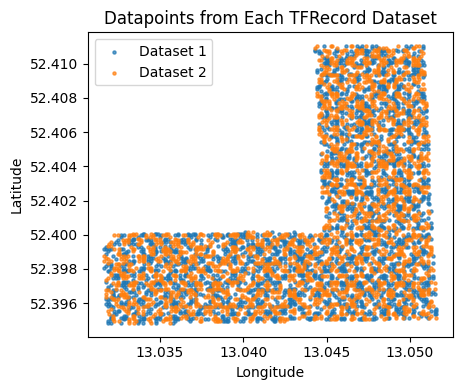

TRAINING HISTORY



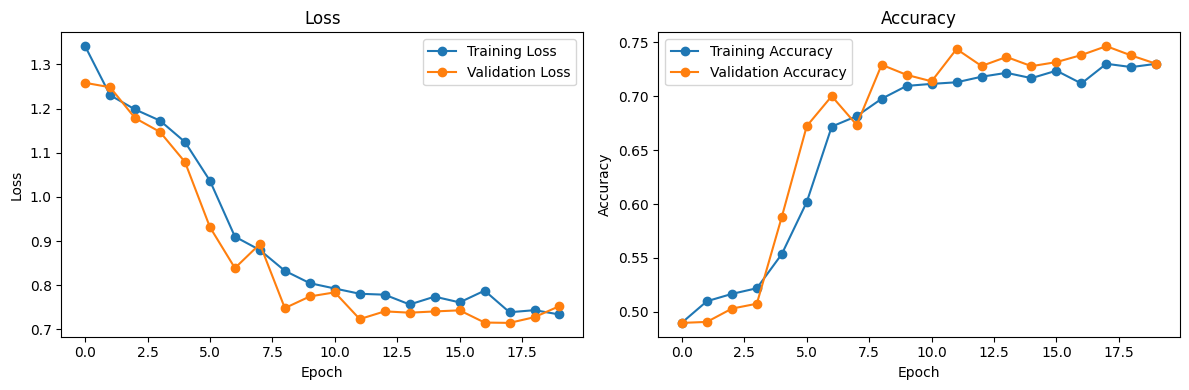

160/160 ━━━━━━━━━━━━━━━━━━━━ 301s 2s/step - accuracy: 0.7147 - loss: 0.7826
Test Loss: 0.791
Test Accuracy: 0.712


/Users/alessandroardenghi/anaconda3/envs/kmeans/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [18]:
train, test = split_datasets_by_grid([data], grid_size=0.0005)
print('Train and Test Data Distribution:\n')
plot_datapoints_from_datasets([train, test], figsize = (5, 4))
train, val = split_train_val(train, split_ratio=0.8)
train_dataset, val_dataset, test_dataset = build_datasets(train, val, test, parse_easy)

model_0005 = tf.keras.models.load_model('saved_models/best_model_0005.keras')
print('TRAINING HISTORY\n')
history = plot_history('saved_models/history_01.json')

test_loss, test_accuracy = model_0005.evaluate(test_dataset)
print(f'Test Loss: {test_loss:.3f}')
print(f'Test Accuracy: {test_accuracy:.3f}')

2025-02-23 18:27:26.643216: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train and Test Data Distribution:



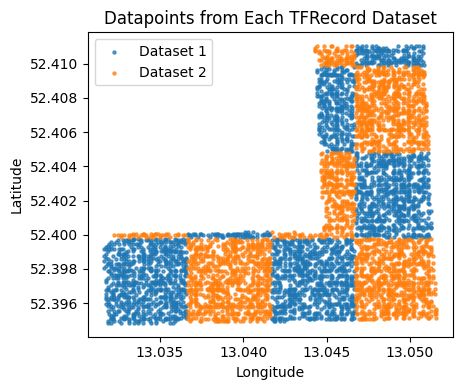

TRAINING HISTORY



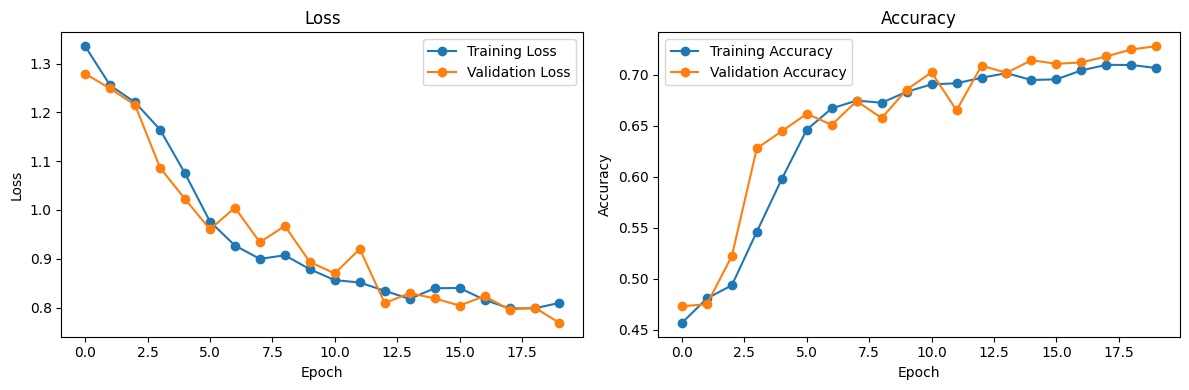

160/160 ━━━━━━━━━━━━━━━━━━━━ 275s 2s/step - accuracy: 0.7258 - loss: 0.7818
Test Loss: 0.765
Test Accuracy: 0.732


/Users/alessandroardenghi/anaconda3/envs/kmeans/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [21]:
train, test = split_datasets_by_grid([data], grid_size=0.005)
print('Train and Test Data Distribution:\n')
plot_datapoints_from_datasets([train, test], figsize = (5, 4))
train, val = split_train_val(train, split_ratio=0.8)
train_dataset, val_dataset, test_dataset = build_datasets(train, val, test, parse_easy)

model_005 = tf.keras.models.load_model('saved_models/best_model_005.keras')
print('TRAINING HISTORY\n')
history = plot_history('saved_models/history_005.json')

test_loss_005, test_accuracy_005 = model_005.evaluate(test_dataset, steps=160)
print(f'Test Loss: {test_loss_005:.3f}')
print(f'Test Accuracy: {test_accuracy_005:.3f}')

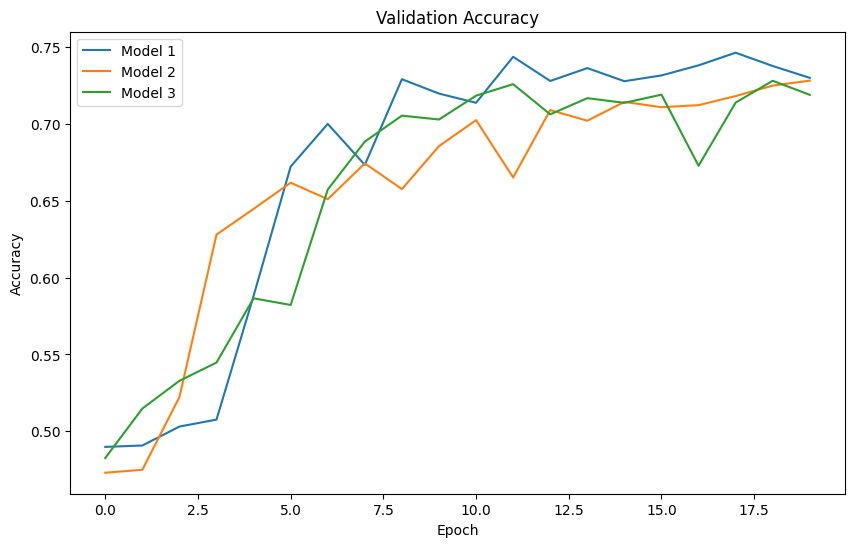

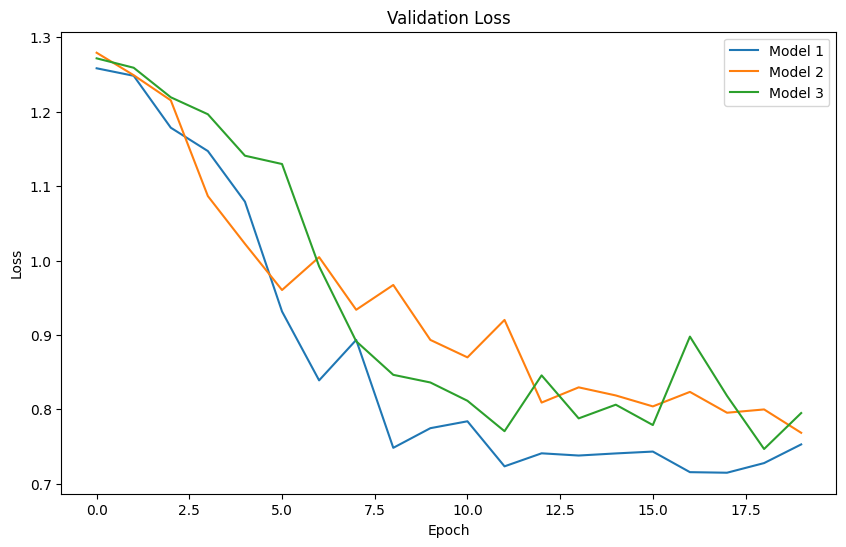

In [ ]:
train, test = split_datasets_by_grid([data], grid_size=0.01)
print('Train and Test Data Distribution:\n')
plot_datapoints_from_datasets([train, test], figsize = (5, 4))
train, val = split_train_val(train, split_ratio=0.8)
train_dataset, val_dataset, test_dataset = build_datasets(train, val, test, parse_easy)

model_01 = tf.keras.models.load_model('saved_models/best_model_005.keras')
print('TRAINING HISTORY\n')
history = plot_history('saved_models/history_005.json')

test_loss_01, test_accuracy_01 = model_01.evaluate(test_dataset, steps=160)
print(f'Test Loss: {test_loss_01:.3f}')
print(f'Test Accuracy: {test_accuracy_01:.3f}')
